The data comes from the paper [AniWho: A Quick and Accurate Way to Classify Anime Character Faces in Images](https://arxiv.org/pdf/2208.11012v3). The dataset consists of 9,738 images across 130 character classes, with approximately 75 images per class, sourced from the Danbooru website—a platform developed by the Japanese animation-style cartoon community.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import os
import zipfile

In [ ]:
import io
import requests

def load_images_from_zip(zip_file):
    with zipfile.ZipFile(zip_file, "r") as zip_ref:
        images = {"anastasia": [], "takao": []} # arcueid_brunestud, yukinoshita_yukino

        for file_name in zip_ref.namelist():
            if file_name.startswith("anastasia") and file_name.endswith("jpg"):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert("RGB")
                    images["anastasia"].append(np.array(img))
            elif file_name.startswith('takao') and file_name.endswith('.jpg'):
                with zip_ref.open(file_name) as file:
                    img = Image.open(file).convert('RGB')
                    images['takao'].append(np.array(img))

    return images

zip_file_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/xZQHOyN8ONT92kH-ASb4Pw/data.zip"

# download zipfile
response = requests.get(zip_file_url)
zip_file_bytes = io.BytesIO(response.content)

# load images from zip file
images = load_images_from_zip(zip_file_bytes)

In [3]:
print(len(images["anastasia"]))
print(len(images["takao"]))

50
50


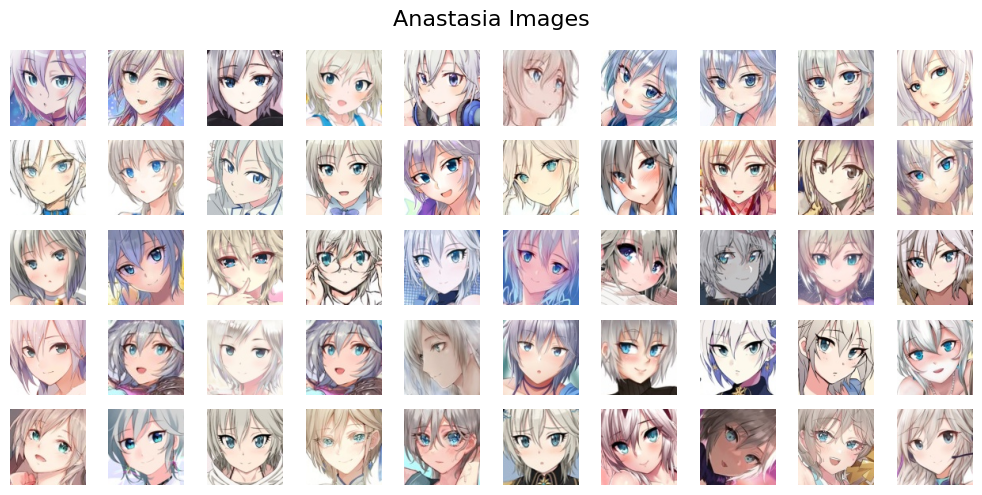

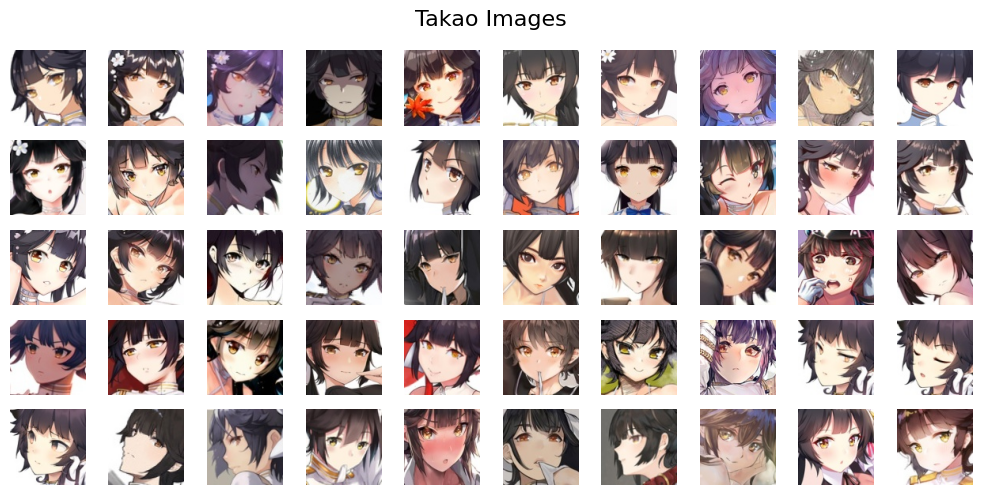

In [5]:
def plot_images(images, title):
    fig, axes = plt.subplots(5, 10, figsize=(10,5))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()

    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


# plot images for anastasia
plot_images(images["anastasia"], "Anastasia Images")
# plot images for takao
plot_images(images["takao"], "Takao Images")

In [7]:
class AnimeDataset(Dataset):
    def __init__(self, images, transform=None, classes=None):
        self.images = []
        self.labels = []
        self.transform = transform
        self.classes = classes

        for label, class_name in enumerate(self.classes):
            for img in images[class_name]:
                self.images.append(img)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = Image.fromarray(self.images[index])
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label
    

# define transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# load dataset
dataset = AnimeDataset(images, transform=transform, classes=["anastasia", "takao"])

In [11]:
# split dataset to 80% training and 20% validation

from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler


seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# generate a list of indeces for the entire dataset
indices = list(range(len(dataset)))

# split the indices into training and validation sets
train_indeces, val_indeces = train_test_split(indices, test_size=0.2, random_state=seed)

# create samplers for training and validation sets
train_sampler = SubsetRandomSampler(train_indeces)
val_sampler = SubsetRandomSampler(val_indeces)

# create dataloader objects for training and validation sets
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=20, sampler=val_sampler)

# print the sizes 
print(f"Entire Dataset: {len(dataset)}")
print(f"Train size: {len(train_indeces)}")
print(f"Validation size: {len(val_indeces)}")

Entire Dataset: 100
Train size: 80
Validation size: 20


In [15]:
dataset[0][0].shape

torch.Size([3, 64, 64])

In [16]:
import torch.nn.functional as F

class AnimeCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net_1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.net_2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_1 = nn.Linear(64 * 16 * 16, 128)
        self.fc_2 = nn.Linear(128, 2)
    
    def forward(self, x):
        x = self.net_2(self.net_1(x)).view(-1, 64*16*16) 
        return self.fc_2(F.relu(self.fc_1(x)))

In [17]:
model = AnimeCNN()
model

AnimeCNN(
  (net_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (net_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_1): Linear(in_features=16384, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=2, bias=True)
)

In [18]:
# print tensor shapes of each layer in the model

input_tensor = torch.randn(1, 3, 64, 64)

def print_size(module, input, output):
    print(f"{module.__class__.__name__} output size: {output.size()}")

# register hooks
hooks = []
for layer in model.children():
    hook = layer.register_forward_hook(print_size)
    hooks.append(hook)

# inspect output sizes
with torch.no_grad():
    output = model(input_tensor)
print(f"final output size: {output.size()}")

# remove hooks
for hook in hooks:
    hook.remove()

Sequential output size: torch.Size([1, 32, 32, 32])
Sequential output size: torch.Size([1, 64, 16, 16])
Linear output size: torch.Size([1, 128])
Linear output size: torch.Size([1, 2])
final output size: torch.Size([1, 2])


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            outputs = model(x)
            loss = criterion(outputs, y)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")

print("Finished training!")

Epoch: 1 | Train loss: 0.7333 | Val loss: 0.1828
Epoch: 2 | Train loss: 0.1857 | Val loss: 0.0011
Epoch: 3 | Train loss: 0.0471 | Val loss: 0.0005
Epoch: 4 | Train loss: 0.0086 | Val loss: 0.0003
Epoch: 5 | Train loss: 0.0009 | Val loss: 0.0002
Finished training!


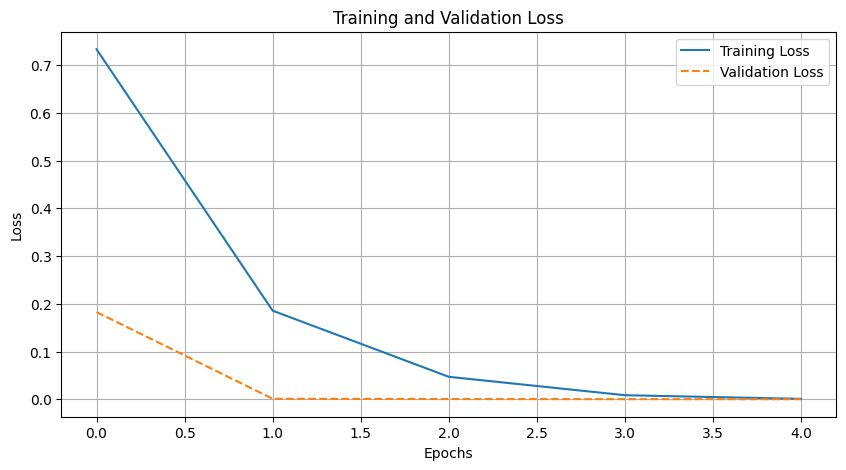

In [21]:
# Plotting the training and validation loss

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

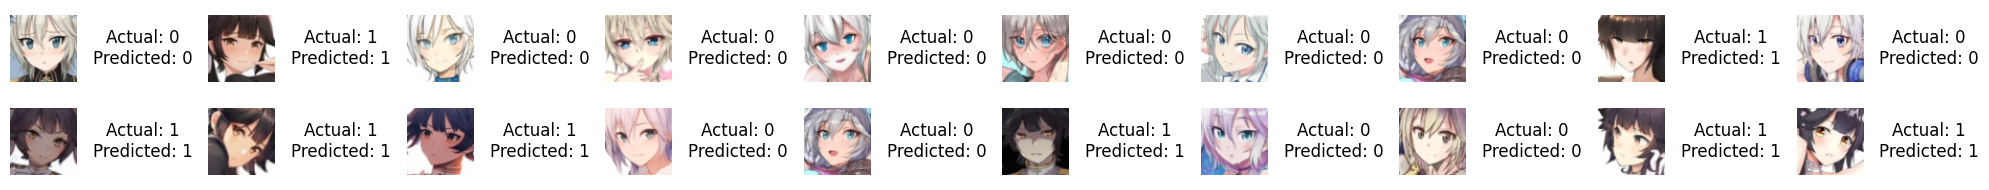

In [22]:
# evaluate the model on unseen data

def imshow(img, ax):
    img = img  / 2 + 0.5 # unnormalized
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0))) # transform dimensions to match matplotlib's expexted format
    ax.axis("off")

# 
model.eval()

data_iter = iter(val_loader)
images, labels = next(data_iter)
outputs = model(images)
_, predicted = torch.max(outputs, 1)


# define grid size
num_images = len(images)
num_cols = 10
num_rows = 2

fig, axs = plt.subplots(num_rows, num_cols * 2, figsize=(20, num_rows))

for idx in range(num_images):
    row = idx // num_cols
    col = (idx % num_cols) * 2

    # plot the image
    imshow(images[idx].cpu(), axs[row, col])

    # display the actual and predicted labels
    axs[row, col + 1].text(0.5, 0.5, f"Actual: {labels[idx].item()}\nPredicted: {predicted[idx].item()}",
                           horizontalalignment="center", verticalalignment="center", fontsize=12)
    axs[row, col + 1].axis("off")

# turn off any remaining subplots
for idx in range(num_images, num_rows*num_cols):
    row = idx // num_cols
    col = (idx % num_cols) * 2
    axs[row, col].axis("off")
    axs[row, col + 1].axis("off")

plt.tight_layout()
plt.show()


In [23]:
# calculate accuracy on validation set

correct = 0
total = 0

# Compute overall accuracy
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f'correct: {correct}, total: {total}')

print(f'Validation Accuracy: {100 * correct / total:.2f}%')

correct: 20, total: 20
Validation Accuracy: 100.00%


In [ ]:
# using leaky relu activation

class AnimeCNN_leaky_relu(nn.Module):
    def __init__(self):
        super().__init__()
        # Add padding=1 to maintain the border
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))  # # #
        x = self.pool(F.leaky_relu(self.conv2(x)))  # # #
        x = x.view(-1, 64 * 16 * 16)
        x = F.leaky_relu(self.fc1(x))  # # #
        x = self.fc2(x)
        return x

Epoch: 1 | Train loss: 0.6928 | Val loss: 0.6856
Epoch: 2 | Train loss: 0.6928 | Val loss: 0.6856
Epoch: 3 | Train loss: 0.6928 | Val loss: 0.6856
Epoch: 4 | Train loss: 0.6928 | Val loss: 0.6856
Epoch: 5 | Train loss: 0.6928 | Val loss: 0.6856
Finished training!


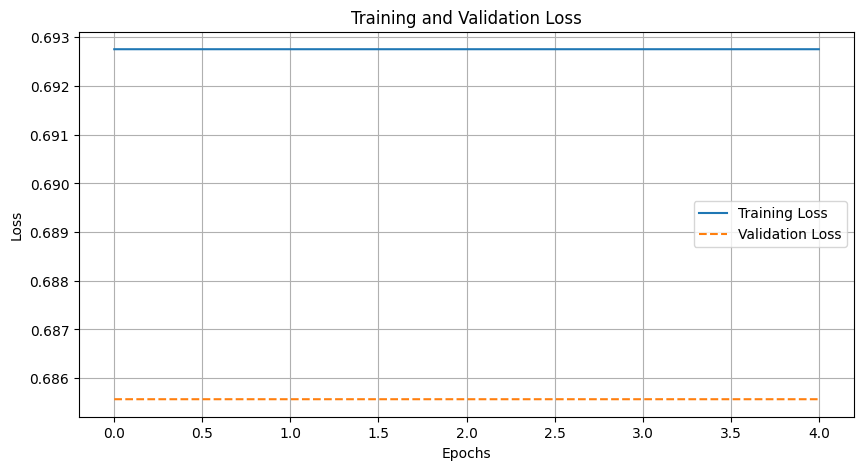

In [30]:
model = AnimeCNN_leaky_relu()

def train(model, num_epochs=5):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}")

    print("Finished training!")

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title('Training and Validation Loss')
    plt.show()


train(model, 5)

Epoch: 1 | Train loss: 0.6928 | Val loss: 0.6856
Epoch: 2 | Train loss: 0.6928 | Val loss: 0.6856
Epoch: 3 | Train loss: 0.6928 | Val loss: 0.6856
Epoch: 4 | Train loss: 0.6928 | Val loss: 0.6856
Epoch: 5 | Train loss: 0.6928 | Val loss: 0.6856
Epoch: 6 | Train loss: 0.6928 | Val loss: 0.6856
Epoch: 7 | Train loss: 0.6928 | Val loss: 0.6856
Epoch: 8 | Train loss: 0.6928 | Val loss: 0.6856
Epoch: 9 | Train loss: 0.6928 | Val loss: 0.6856
Epoch: 10 | Train loss: 0.6928 | Val loss: 0.6856
Finished training!


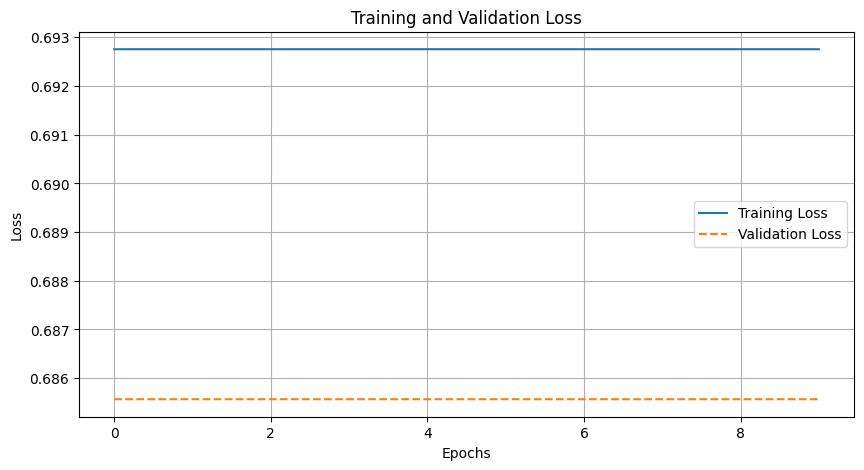

In [32]:
train(model, 10)